In [38]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
#import imageio, skimage

import torch

from collections import Counter

In [41]:
%load_ext autoreload
%autoreload 2

In [16]:
from virtex.data.datasets.arch_captions import ArchCaptionsDatasetRaw

## Unified Dataset Class for ARCH Dataset

In [17]:
arch_dataset_raw_train = ArchCaptionsDatasetRaw(data_root='../datasets/ARCH',
                                                source="both",
                                                split="train")
len(arch_dataset_raw_train.instances)

5196

## Unified Dataset Class + augmentations and collate function

In [47]:
from virtex.data import transforms as T

In [273]:
import random
from typing import Callable, Dict, List

import albumentations as alb
import numpy as np
import torch
from torch.utils.data import Dataset

from virtex.data.tokenizers import SentencePieceBPETokenizer
from virtex.data import transforms as T
from virtex.data.datasets.arch_captions import ArchCaptionsDatasetRaw


class ArchCaptioningDatasetExtended(Dataset):
    r"""
    A dataset which provides image-caption (forward and backward) pairs from
    a ARCH Captions annotation file. This is used for pretraining tasks which
    use captions - bicaptioning, forward captioning and token classification.

    Args:
        data_root: Path to dataset directory containing images and annotations.
        source: Name of ARCH source to read. One of ``{"pubmed", "books", "both"}``.
            "both" option results in a concatenation of the datasets from "pubmed" and "books"
        split: Name of ARCH split to read. One of ``{"train", "val", "all"}``.
        tokenizer: Tokenizer which maps word tokens to their integer IDs.
        image_transform: List of image transformations, from either
            `albumentations <https://albumentations.readthedocs.io/en/latest/>`_
            or :mod:`virtex.data.transforms`.
        max_caption_length: Maximum number of tokens to keep in caption tokens.
            Extra tokens will be trimmed from the right end of the token list.
    """

    def __init__(
        self,
        data_root: str,
        split: str,
        tokenizer: SentencePieceBPETokenizer,
        source: str="both",
        image_transform: Callable = T.DEFAULT_IMAGE_TRANSFORM,
        flip_transform: Callable = None,
        max_caption_length: int = 30,
    ):
        self._dset = ArchCaptionsDatasetRaw(data_root=data_root, source=source, split=split)
        self.image_transform = image_transform
        self.flip_transform = flip_transform
        self.caption_transform = alb.Compose(
            [
                T.NormalizeCaption(),
                T.TokenizeCaption(tokenizer),
                T.TruncateCaptionTokens(max_caption_length),
            ]
        )
        self.padding_idx = tokenizer.token_to_id("<unk>")

    def __len__(self):
        return len(self._dset)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        # keys: {"image_ids", "images", "caption"}
        instance = self._dset[idx]
        image_ids, images, caption = (
            instance["image_ids"],
            instance["images"],
            instance["caption"],
        )
        
        # debugging
        print("Checkpoint 1")
        
        # List[int] -> np.array of shape (len(image_ids), )
        image_ids = np.array(image_ids)
        # (len(image_ids), ) -> (len(image_ids), 1)
        image_ids = image_ids.reshape((image_ids.shape[0], 1))
        
        
        # debugging
        print("Checkpoint 2")
        
        # Transform images, no flips at this stage not to create multiple versions of the caption!
        #     Before flipping all images need to be resized to the same size to put them into a tensor.
        #     Caption won't be tokenized/processed here.
        #     Albumentations transforms require named arguments - can't avoid it.
        images = [self.image_transform(image=image)["image"] for image in images]
        
        # # debugging
        print("Checkpoint 3")
        
        # Convert each image from HWC to CHW format and convert to tensors:
        #     Transforms expect to receive tensors in (B, C, H, W) shape
        #     [(Channel, Height, Width), ..., ] Bag Size times
        images = [np.transpose(image, (2, 0, 1)) for image in images]
        images = [torch.tensor(image, dtype=torch.float) for image in images]

        # # debugging
        print("Checkpoint 4")
        
        # stack all the images into a tensor: (bag_size=batch_size, Channel, Height, Width)
        images = torch.stack(images, dim=0)

        if self.flip_transform is not None:
            # perform tensor transforms on images in the tensor and the
            # corresponding caption, e.g. random horizontal flips
            # Reason: single version of the caption should appear => random flip
            # should be performed on all images in a bag
            images_caption = self.flip_transform(image=images, caption=caption)
            images, caption = images_caption["image"], images_caption["caption"]

        print(images)
        print(caption)

        # # debugging
        print("Checkpoint 5")

        # caption tokens
        caption_tokens = self.caption_transform(caption=caption)["caption"]

        # # debugging
        print("Checkpoint 6")

        return {
            "image_ids": torch.tensor(image_ids, dtype=torch.long), # ((Bag size, 1)
            "images": images,
            "caption_tokens": torch.tensor(caption_tokens, dtype=torch.long),
            "noitpac_tokens": torch.tensor(caption_tokens, dtype=torch.long).flip(0),
            "caption_lengths": torch.tensor(len(caption_tokens), dtype=torch.long),
        }

    def collate_fn(
        self, data: List[Dict[str, torch.Tensor]]
    ) -> Dict[str, torch.Tensor]:

        # Pad `caption_tokens` and `masked_labels` up to this length.
        caption_tokens = torch.nn.utils.rnn.pad_sequence(
            [d["caption_tokens"] for d in data],
            batch_first=True,
            padding_value=self.padding_idx,
        )
        noitpac_tokens = torch.nn.utils.rnn.pad_sequence(
            [d["noitpac_tokens"] for d in data],
            batch_first=True,
            padding_value=self.padding_idx,
        )
        return {
            "image_id": torch.stack([d["image_ids"] for d in data], dim=0),
            "image": torch.stack([d["images"] for d in data], dim=0),
            "caption_tokens": caption_tokens,
            "noitpac_tokens": noitpac_tokens,
            "caption_lengths": torch.stack([d["caption_lengths"] for d in data]),
        }


In [274]:
# check the default transform
T.DEFAULT_IMAGE_TRANSFORM

Compose([
  SmallestMaxSize(always_apply=False, p=1.0, max_size=256, interpolation=1),
  CenterSquareCrop(always_apply=False, p=1.0, height=224, width=224),
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [275]:
T.DEFAULT_TENSOR_TRANSFORM

AttributeError: module 'virtex.data.transforms' has no attribute 'DEFAULT_TENSOR_TRANSFORM'

In [276]:
#help(SentencePieceBPETokenizer)

In [302]:
arch_tokenizer = SentencePieceBPETokenizer("../datasets/vocab/arch_10k.model")

arch_dataset_extended = ArchCaptioningDatasetExtended(data_root='../datasets/ARCH',
                                                      split="train",
                                                      tokenizer=arch_tokenizer,
                                                      flip_transform=None)
len(arch_dataset_extended)

5196

In [303]:
sample_item = arch_dataset_extended.__getitem__(0)
sample_item

Checkpoint 1
Checkpoint 2
Checkpoint 3
Checkpoint 4
tensor([[[[ 1.5125,  1.2214,  1.3242,  ...,  1.3242,  1.0844,  1.1529],
          [ 0.7762,  1.0844,  1.4269,  ...,  1.1872,  1.5468,  1.1529],
          [ 1.0159,  0.7591,  0.8447,  ...,  1.5639,  1.6153,  1.4783],
          ...,
          [-0.5253,  0.0398, -0.3541,  ...,  0.9474,  0.6049,  0.8276],
          [ 0.1768, -0.1143, -0.7308,  ...,  1.1529,  0.9817,  1.0331],
          [ 0.4851, -0.0287, -0.8507,  ...,  1.4783,  1.2557,  1.1700]],

         [[ 0.7129,  0.4678,  0.7304,  ...,  0.8704,  0.4678,  0.5203],
          [-0.0049,  0.4328,  0.9230,  ...,  1.0280,  1.3081,  0.8354],
          [ 0.4153,  0.1877,  0.4328,  ...,  1.3606,  1.4307,  1.2031],
          ...,
          [-0.8102, -0.0574, -0.2325,  ...,  1.0105,  0.3452,  0.3277],
          [-0.4251, -0.5301, -0.8277,  ...,  1.2381,  0.6954,  0.8529],
          [-0.2850, -0.6352, -1.1429,  ...,  1.5182,  0.9930,  1.1155]],

         [[ 1.8557,  1.5420,  1.6988,  ...,  1.838

{'image_ids': tensor([[0],
         [1]]),
 'images': tensor([[[[ 1.5125,  1.2214,  1.3242,  ...,  1.3242,  1.0844,  1.1529],
           [ 0.7762,  1.0844,  1.4269,  ...,  1.1872,  1.5468,  1.1529],
           [ 1.0159,  0.7591,  0.8447,  ...,  1.5639,  1.6153,  1.4783],
           ...,
           [-0.5253,  0.0398, -0.3541,  ...,  0.9474,  0.6049,  0.8276],
           [ 0.1768, -0.1143, -0.7308,  ...,  1.1529,  0.9817,  1.0331],
           [ 0.4851, -0.0287, -0.8507,  ...,  1.4783,  1.2557,  1.1700]],
 
          [[ 0.7129,  0.4678,  0.7304,  ...,  0.8704,  0.4678,  0.5203],
           [-0.0049,  0.4328,  0.9230,  ...,  1.0280,  1.3081,  0.8354],
           [ 0.4153,  0.1877,  0.4328,  ...,  1.3606,  1.4307,  1.2031],
           ...,
           [-0.8102, -0.0574, -0.2325,  ...,  1.0105,  0.3452,  0.3277],
           [-0.4251, -0.5301, -0.8277,  ...,  1.2381,  0.6954,  0.8529],
           [-0.2850, -0.6352, -1.1429,  ...,  1.5182,  0.9930,  1.1155]],
 
          [[ 1.8557,  1.5420,  1.

In [285]:
sample_item['images'].size()

torch.Size([2, 3, 224, 224])

In [135]:
sample_tensor_image = sample_item['images'][0]
sample_tensor_image

tensor([[[212., 195., 201.,  ..., 201., 187., 191.],
         [169., 187., 207.,  ..., 193., 214., 191.],
         [183., 168., 173.,  ..., 215., 218., 210.],
         ...,
         [ 93., 126., 103.,  ..., 179., 159., 172.],
         [134., 117.,  81.,  ..., 191., 181., 184.],
         [152., 122.,  74.,  ..., 210., 197., 192.]],

        [[157., 143., 158.,  ..., 166., 143., 146.],
         [116., 141., 169.,  ..., 175., 191., 164.],
         [140., 127., 141.,  ..., 194., 198., 185.],
         ...,
         [ 70., 113., 103.,  ..., 174., 136., 135.],
         [ 92.,  86.,  69.,  ..., 187., 156., 165.],
         [100.,  80.,  51.,  ..., 203., 173., 180.]],

        [[210., 192., 201.,  ..., 209., 193., 192.],
         [176., 192., 214.,  ..., 206., 228., 201.],
         [199., 182., 188.,  ..., 228., 233., 220.],
         ...,
         [145., 173., 149.,  ..., 199., 178., 173.],
         [158., 153., 135.,  ..., 213., 190., 193.],
         [162., 148., 128.,  ..., 235., 206., 208.]]]

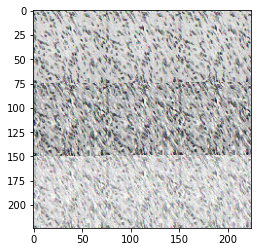

In [136]:
plt.imshow(sample_tensor_image.to(int).view(sample_tensor_image.shape[1],
                                     sample_tensor_image.shape[2], sample_tensor_image.shape[0]))

### Examples of TensorHorisontalFlip

In [213]:
flip = T.TensorHorizontalFlip(p=0.5)
img_tensor = torch.Tensor([[[1, 1, 0, 0] for _ in range(4)],
                           [[0, 0, 1, 1] for _ in range(4)]])
print(img_tensor.shape)
img_tensor

torch.Size([2, 4, 4])


tensor([[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.]],

        [[0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.]]])

In [215]:
image_caption = flip(image=img_tensor, caption="1-s are to the left on the "
                                               "first image and to the right "
                                               "on the second")
print(image_caption['image'])
print(image_caption['caption'])

tensor([[[0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [0., 0., 1., 1.]],

        [[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.]]])
1-s are to the right on the first image and to the left on the second


### Checking if the horiontal flip can be applied to images separately in torchvision

In [11]:
import torchvision
from PIL import Image
test_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()]
)

fixed_test_transform = test_transform

In [12]:
test_list = [np.array([1, 1, 0, 0], dtype=np.float32).reshape((1, 4)) for _ in range(100)]
test_list

[array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1., 1., 0., 0.]], dtype=float32),
 array([[1.

In [13]:
[fixed_test_transform(l) for l in test_list]

[tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor([[[0., 0., 1., 1.]]]),
 tensor([[[1., 1., 0., 0.]]]),
 tensor(

It can not be applied separately, so the flip needs to be applied on the tensor